In [3]:
!pip install yahoo_fin

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/50.1 kB ? eta -:--:--
     ------------------------ --------------- 30.7/50.1 kB 1.4 MB/s eta 0:00:01
     ------------------------------- ------ 41.0/50.1 kB 495.5 kB/s eta 0:00:01
     -------------------------------------- 50.1/50.1 kB 423.9 kB/s eta 0:00:00
     ---------------------------------------- 0.0/84.9 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/84.9 kB ? eta -:--:--
     ------------- ------------------------ 30.7/84.9 kB 325.1 kB/s eta 0:00:01
     ------------------ ------------------- 41.0/84.9 kB 388.9 kB/s eta 0:00:01
     --------------------------- ---------- 61.4/84.9 kB 326.1 kB/s eta 0:00:01
     --------------------------- ---------- 61.4/84.9 kB 326.1 kB/s eta 0:00:01
     --------------------------- ---------- 61.4/84.9 kB 326.1 kB/s eta 0:00:01
     --------------------------- --------

In [4]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [5]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [6]:
# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

In [7]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

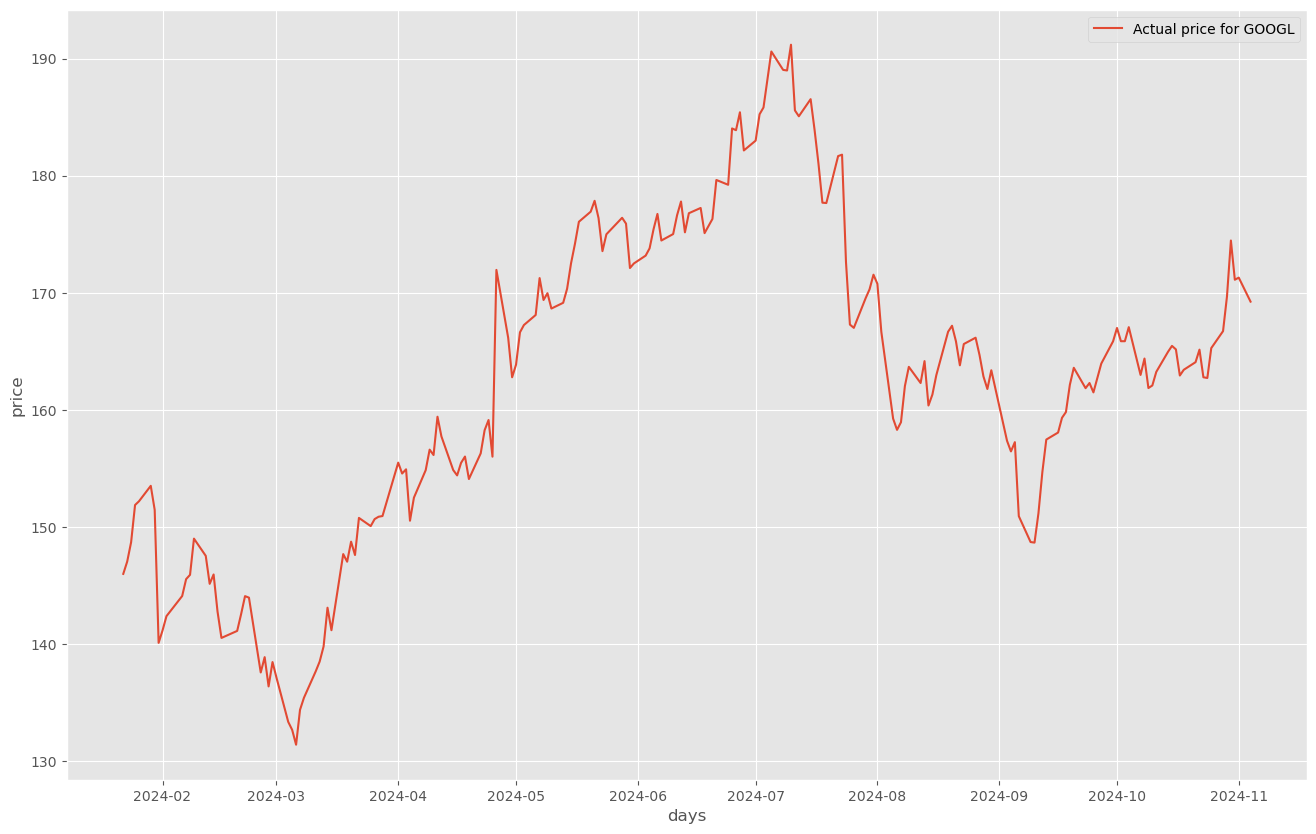

In [8]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [9]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [10]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['close'].shift(-days)
  last_sequence = np.array(df[['close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [11]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [12]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

D:\usr\anaconda312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0387
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0033
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0036
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0030
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0027
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0035
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0023
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0025
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0023
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0021
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0020
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0020
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0021
Epo

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


D:\usr\anaconda312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0383
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0038
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0037
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0046
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0036
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0033
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0033
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0023
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0029
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0026
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0025
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0023
Epoc

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 7, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


D:\usr\anaconda312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0481
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0054
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0040
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0042
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0042
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0037
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0039
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0038
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0036
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029
Epo

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 7, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 20)                  │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [13]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


ValueError: cannot set a row with mismatched columns